The code in this file creates a CSV file with the predictions for all images in the file containing the images (defined in Config.images_folder_path).
The CSV format is:


Image Name, x1, y1, x2, y2, Error Prediction

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import torch
import random
import csv

from Config import Config
from Models import PreTrainedKPD, PreTrainedConf, Tools

In [23]:
import os

# Useful function, as images without background and original images share the same name but with .jpg and .png respectively !
# We run our predictions on images without background as there is less noise to fool the models.

def replace_jpg_with_png(directory):
    """
    Lists the names of the images in a given directory and replaces their 
    suffix by .png if they are .jpg.

    Args:
        directory (str): The path to the directory containing the images.

    Returns:
        list: A list of filenames with updated suffixes.
    """
    if not os.path.isdir(directory):
        raise ValueError(f"{directory} is not a valid directory")

    updated_filenames = []

    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            # Replace the suffix
            new_filename = os.path.splitext(filename)[0] + '.png'
            updated_filenames.append(new_filename)
        else:
            # Keep the filename as is
            updated_filenames.append(filename)

    return updated_filenames

In [24]:
# List all the images names in the original images folder.
image_names = replace_jpg_with_png(Config.original_images_folder_path)

In [31]:
# MPS is the CUDA (GPU) equivalent on Macs for much faster predictions.
device = torch.device(Config.device if Config.is_available() else "cpu")
print(f"Device: {device}")
Config.device

Device: cpu


'mps'

In [26]:
"""
Load the model weights.
"""

kpd_model = PreTrainedKPD.KeypointDetectionModel().to(device)
kpd_model.load_state_dict(torch.load("Models/Saves/pretrainedKPD_weights00166.pth", map_location=device))

conf_model = PreTrainedConf.ConfidenceModel().to(device)
conf_model.load_state_dict(torch.load("Models/Saves/pretrainedConf_weights00166.pth", map_location=device))

/home/wene/miniconda3/envs/mlenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wene/miniconda3/envs/mlenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_63239/4165964646.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/ma

<All keys matched successfully>

In [27]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

Normalized error prediction =  0.3420587182044983


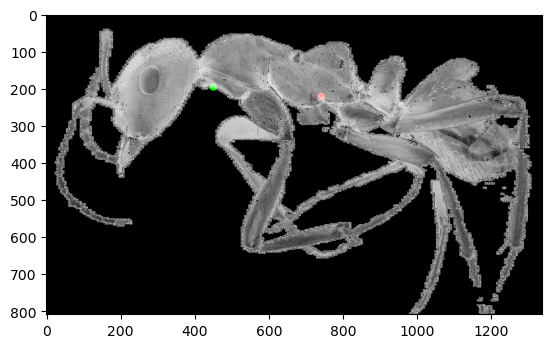

------------------------


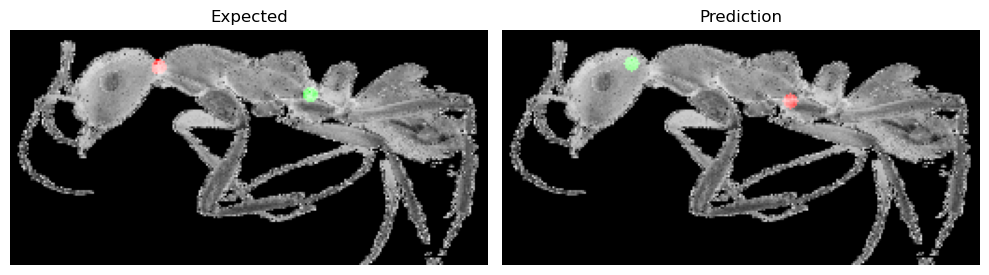

Normalized error prediction =  0.3464764654636383


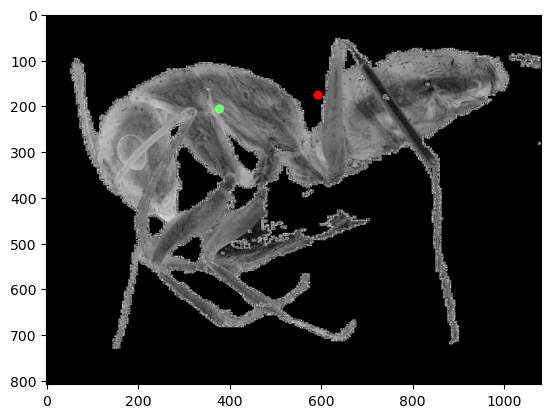

------------------------


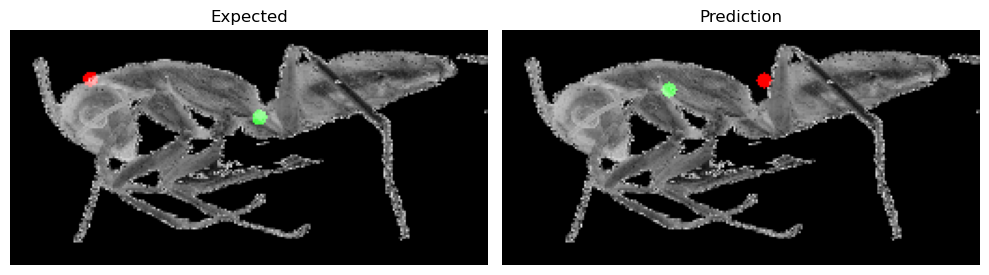

Normalized error prediction =  0.32819098234176636


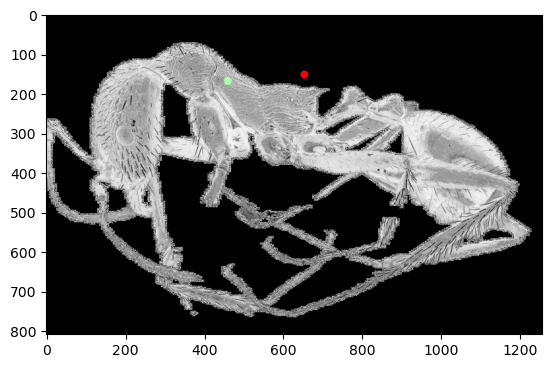

------------------------


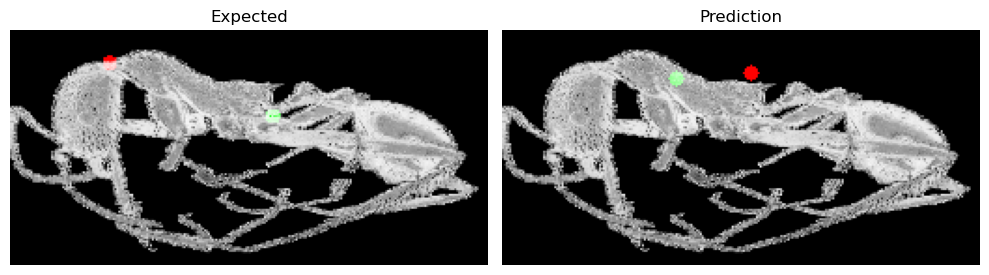

Normalized error prediction =  0.3213726282119751


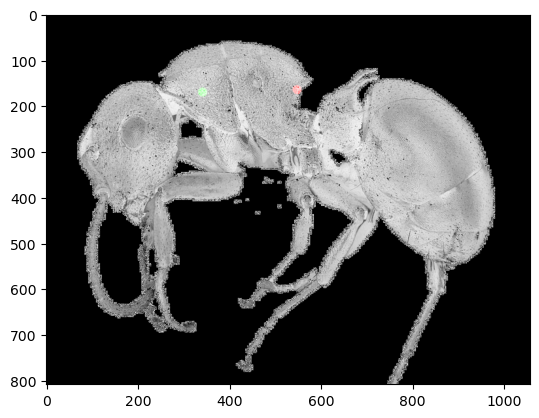

------------------------


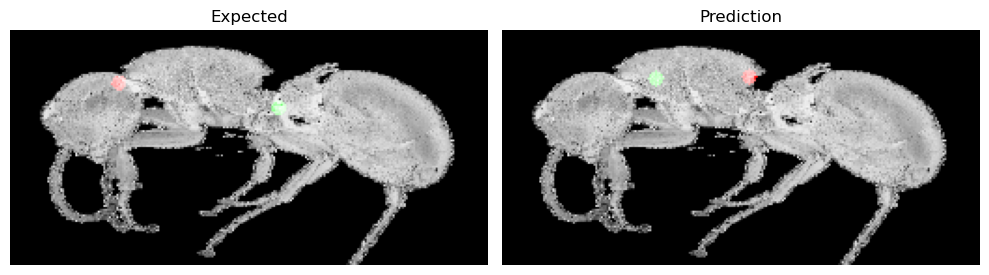

Normalized error prediction =  0.3890072703361511


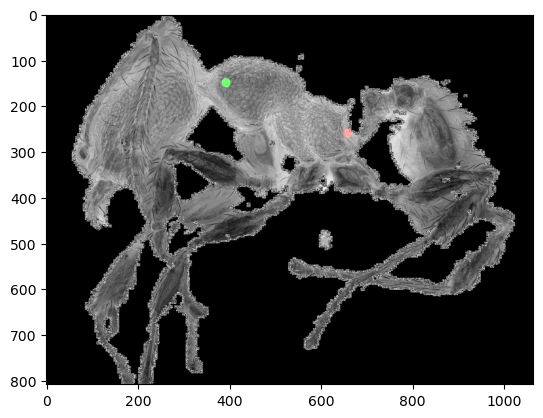

------------------------


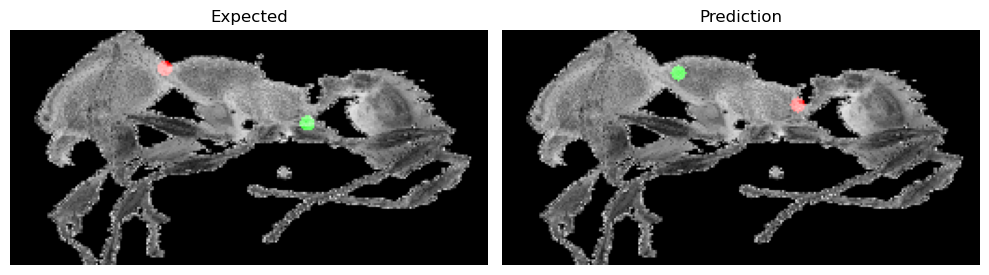

In [28]:
"""
Check that the models and the coordinates transformations work (more or less) before spending 30min predicting 30'000+ images.
The models predict normalized coordinates on downsampled images, so the math we are doing to revert the coordinates back to the original images
has to be correct.
Below are some predictions of the models on the original image and on the downsampled input image.
"""
for point in random.sample(data, 5):
    name = Config.images_folder_path+"/"+point["Image Name"]
    Tools.plot_model_prediction_on_original_image(kpd_model, name, conf_model)
    Tools.plot_model_prediction(kpd_model, [point], 1)

Normalized error prediction =  0.3343419134616852


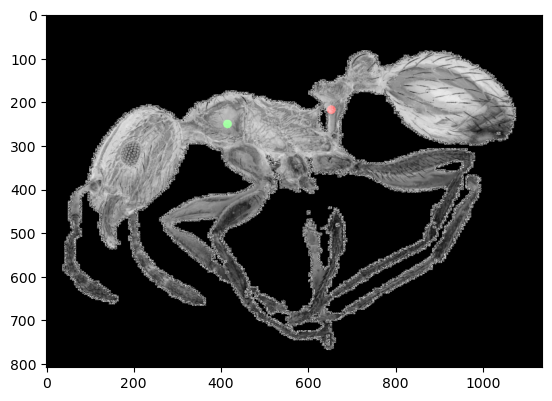

------------------------
Normalized error prediction =  0.23193573951721191


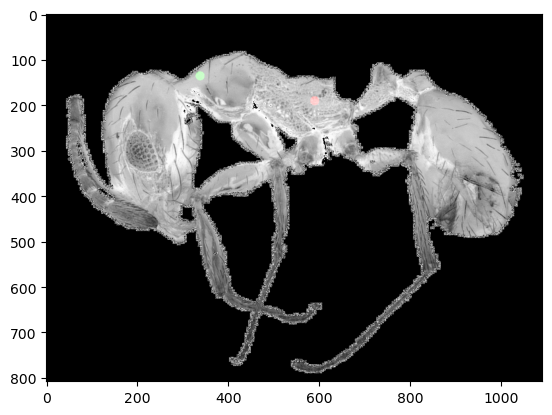

------------------------
Normalized error prediction =  0.38080766797065735


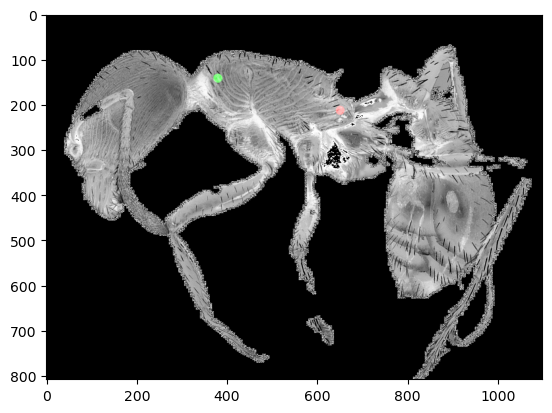

------------------------
Normalized error prediction =  0.2766491770744324


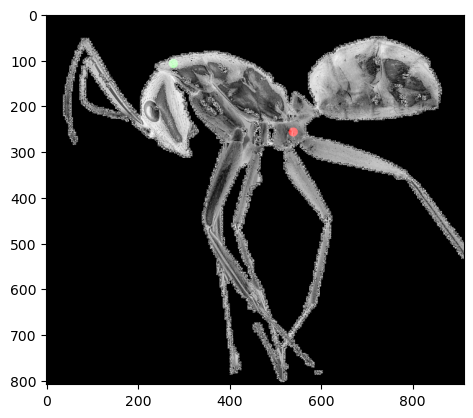

------------------------
Normalized error prediction =  0.1896670013666153


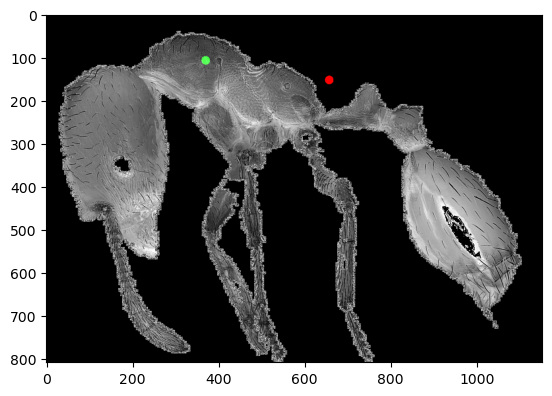

------------------------


In [44]:
"""
We just checked some model predictions on training/test set, below are predictions on images the model has never seen.
"""
for image_name in random.sample(image_names, 5):
    path = Config.images_folder_path + "/" + image_name
    Tools.plot_model_prediction_on_original_image(kpd_model, path, conf_model)

In [45]:
pred_data = []
i = 0
for image_name in image_names:
    i += 1
    if not i%1000:
        print("Predicting keypoints on all images - ", int(100*i/len(image_names)), "%")
    pred = Tools.get_original_image_pred(kpd_model, Config.images_folder_path + "/"+image_name, conf_model=conf_model)
    pred_dict = {"Image Name": image_name, "x1": pred[0], "y1": pred[1], "x2": pred[2], "y2": pred[3], "Error estimate": pred[4]}
    pred_data.append(pred_dict)

Predicting keypoints on all images -  5 %
Predicting keypoints on all images -  11 %


[ WARN:0@2583.632] global loadsave.cpp:241 findDecoder imread_('clean/Autorun.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
print(pred_data[:10])

In [14]:
def dicts_to_csv(dict_list, output_file):
    """
    Writes a list of dictionaries to a CSV file.

    Args:
        dict_list (list): List of dictionaries with identical keys.
        output_file (str): Path to the output CSV file.

    Returns:
        None
    """
    if not dict_list:
        raise ValueError("The list of dictionaries is empty")

    # Extract headers from the first dictionary
    headers = dict_list[0].keys()

    with open(output_file, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        writer.writerows(dict_list)

In [15]:
# Create the CSV file with our predictions
dicts_to_csv(pred_data, "CSVs/predictions_17december.csv")